<a href="https://colab.research.google.com/github/Eddy-Emmanuel/Next-word-predictor-LSTM-and-GRU/blob/main/Next_word_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'next-word-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2389252%2F4032467%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241005%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241005T193943Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5fd92c929517e86213a8e6098854a34542294c6d181703c8e3bc52f13d1ce7401402c40fe42d908f5e2cc8961c6b503c97d7f1dde6e01bed19b1a359a451a62279e7915af04b5ab97ae832a9aa2113bd7d9708dd6456408b76d03752652e04fda37af569b1d8773f004832a8297e92324ce8a79bb043dcb25983332d04653d2a675d7b169d41672149d650d8379ea6a077b4469e3ceaacbadfc5996c5bfdcf61828d1d53926325d842d8dee695782c74bb365039afe2642cfee4ed68682adb7a0c8ee550c508673bd12d0c1f06741167b578adb7906224abd6f10bdc82ba5dabc523e232776d64b1886aa28fd8ae5a5baae93d7573f5d7ad57244ac37e8b986d,clean-text:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5822261%2F9555125%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241005%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241005T193943Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D91a0c65e7cac7c85b94d0d8c67e2364c0105555bebcca44daea55fb6ec7a42fada0a7b538b5fce3b4fdaec45394282a9eb7b3e610670e88439aa91565b4587720c5fb0a24e78cf6888aa1e6fe539f94c203f1fceb1ffdd1ee219efd5f4bfef311d76a6d2fc569860b3c65531b824f05dec1fcaf0f2c6a16a43b27ef89f8811abdc4e6d220c9a1e30ee5db8e55f81f1d510a6eca80f1e50d484c18067e8c251a67aad7ba9cb4574408dd5b508cefea25c075dd682160fbc4a4c9fe9809f2550bcea9759df75688af5b443e80db81639bf21a9b5b16b6ece12c08cd818d21a49747dc340221d71ec99134e407aa23fafe9dce36796032bb27a2bf6a42985fa7627'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# For filtering warnings
from warnings import filterwarnings
filterwarnings(action="ignore")

# For preprocessing
import re, string
import numpy as np
import pandas as pd

# for path matching
from glob import glob

# for spelling correction
from textblob import TextBlob

# for visualization
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras import layers, Input, Sequential, Model, optimizers, callbacks

from sklearn.model_selection import train_test_split

# for progress bar
from tqdm.auto import tqdm
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [ ]:
data_pth = "/kaggle/input/next-word-prediction"
df = pd.read_csv(glob(f"{data_pth}/*.txt")[0], sep="\t", names=["text"])

df

,text
0,Project Gutenberg's The Adventures of Sherlock...
1,This eBook is for the use of anyone anywhere a...
2,almost no restrictions whatsoever. You may co...
3,re-use it under the terms of the Project Guten...
4,with this eBook or online at www.gutenberg.net
...,...
9628,facility: www.gutenberg.org
9629,This Web site includes information about Proje...
9630,including how to make donations to the Project...
9631,"Archive Foundation, how to help produce our ne..."


In [ ]:
df["text"] = df["text"].str.lower()

df

,text
0,project gutenberg's the adventures of sherlock...
1,this ebook is for the use of anyone anywhere a...
2,almost no restrictions whatsoever. you may co...
3,re-use it under the terms of the project guten...
4,with this ebook or online at www.gutenberg.net
...,...
9628,facility: www.gutenberg.org
9629,this web site includes information about proje...
9630,including how to make donations to the project...
9631,"archive foundation, how to help produce our ne..."


In [ ]:
def prep_text(text):
    url_pattern = r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+|www\.[a-zA-Z0-9\-]+(\.[a-zA-Z]+)+'
    txt = re.sub(url_pattern, 'website', text)
    txt = re.sub(r'[^\w\s]', '', txt)
    txt = txt.translate(str.maketrans("", "", string.punctuation))
    txt = re.sub(r'\s+', ' ', txt).strip()
    return str(TextBlob(txt).correct())

In [ ]:
df["text"] = df["text"].progress_apply(prep_text)

df

  0%|          | 0/9633 [00:00<?, ?it/s]

,text
0,project gutenberg the adventures of sherlock h...
1,this ebook is for the use of anyone anywhere a...
2,almost no restrictions whatsoever you may copy...
3,refuse it under the terms of the project guten...
4,with this ebook or online at webster
...,...
9628,facility webster
9629,this web site includes information about proje...
9630,including how to make donations to the project...
9631,archive foundation how to help produce our new...


In [ ]:
df.to_csv("clean_text.csv", index=False)

In [ ]:
clean_df = pd.read_csv("/kaggle/input/clean-text/clean_text.csv")

In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(clean_df["text"])

In [ ]:
total_number_of_words = len(tokenizer.word_index) + 1
total_number_of_words

8506

In [ ]:
tokenizer.word_index

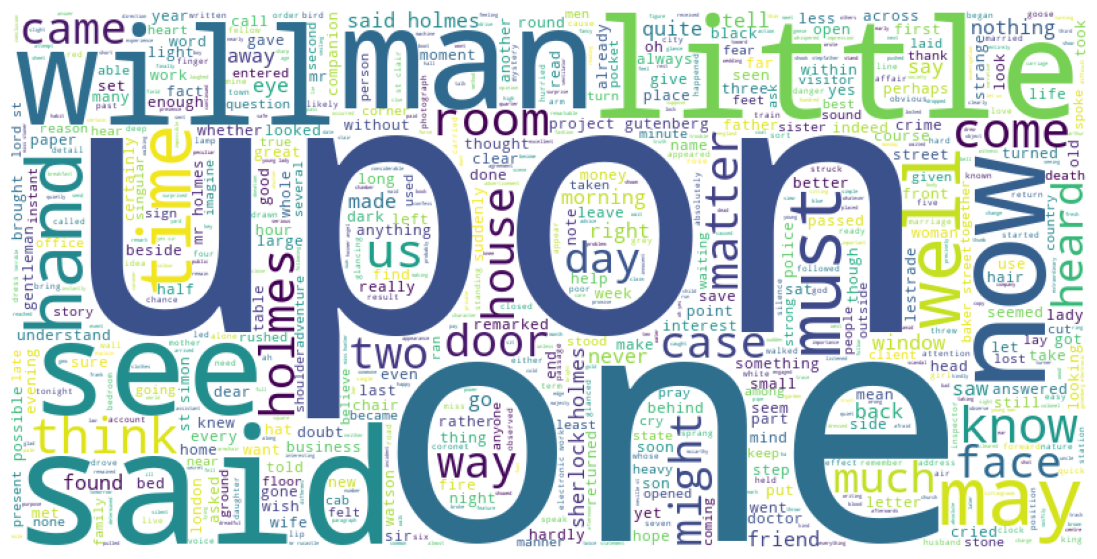

In [ ]:
wrdcloud = WordCloud(width=800,
                     height=400,
                     background_color="white",
                     max_words=total_number_of_words).generate(" ".join(clean_df["text"]))

plt.figure(figsize=(20, 7))
plt.imshow(wrdcloud)
plt.axis('off')
plt.show()

In [ ]:
txt_to_sequence = tokenizer.texts_to_sequences(clean_df["text"])

In [ ]:
max_sentence_length = max(len(i) for i in txt_to_sequence)
max_sentence_length

18

In [ ]:
padded_sequence = pad_sequences(txt_to_sequence, maxlen=max_sentence_length)
padded_sequence

array([[   0,    0,    0, ...,  455, 2096, 2097],
       [   0,    0,    0, ..., 1570,    2,   17],
       [   0,    0,    0, ...,    9,  116,   60],
       ...,
       [   0,    0,    0, ...,  136,  137,  825],
       [   0,    0,    0, ...,    2,   95,    5],
       [   0,    0,    0, ...,   79,  335, 1567]], dtype=int32)

In [ ]:
X = padded_sequence[:, :-1]
y = to_categorical(padded_sequence[:, -1], num_classes=total_number_of_words)

In [ ]:
input_shape = X.shape[1:]
input_shape

(17,)

In [ ]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.3)

In [ ]:
def BuildLSTMModel(input_shape, input_dim, output_dim, num_of_output):
    input_layer = Input(shape=input_shape)
    x = layers.Embedding(input_dim=input_dim, output_dim=output_dim)(input_layer)
    x = layers.LSTM(units=128, activation="tanh")(x)
    x = layers.Dense(units=64, activation="relu")(x)
    output_layer = layers.Dense(units=num_of_output, activation="softmax")(x)

    final_model = Model(input_layer, output_layer)

    final_model.summary()

    final_model.compile(optimizer=optimizers.RMSprop(learning_rate=0.01),
                        loss="categorical_crossentropy",
                        metrics=["accuracy",
                                 tf.keras.metrics.Precision(name="precision"),
                                 tf.keras.metrics.Recall(name="recall")
                                 ]
                        )

    return final_model

In [ ]:
lstm_model = BuildLSTMModel(input_shape,
                            total_number_of_words,
                            max_sentence_length,
                            total_number_of_words)

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_13 (Embedding)        │ (None, 17, 18)         │       153,108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 128)            │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 8506)           │       552,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,518 (3.01 MB)

 Trainable params: 789,518 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = lstm_model.fit(X, y,
                         validation_data=(X, y),
                         epochs=100,
                         batch_size=32,
                         callbacks=[callbacks.ReduceLROnPlateau(patience=5, monitor="val_accuracy"),
                                    callbacks.EarlyStopping(patience=10, monitor="val_accuracy")])

Epoch 1/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.0531 - loss: 7.4126 - precision: 0.0607 - recall: 0.0015 - val_accuracy: 0.0610 - val_loss: 7.0101 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0100
Epoch 2/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0673 - loss: 6.5916 - precision: 0.0278 - recall: 3.3510e-05 - val_accuracy: 0.0905 - val_loss: 6.2566 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0100
Epoch 3/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.0811 - loss: 6.3406 - precision: 0.2485 - recall: 0.0019 - val_accuracy: 0.0910 - val_loss: 6.2331 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0100
Epoch 4/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.0977 - loss: 6.1582 - precision: 0.3443 - recall: 0.0031 - val_accuracy: 0.1043 - val_loss: 6.0388 - val_precision: 0.5526 - val_recall: 0.0022 - learning_rate: 0.0100
Epoch 5/100
302/302 ━━━━━━━━

In [ ]:
lstm_result = pd.DataFrame(history.history)
lstm_result

,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall,learning_rate
0,0.057614,7.045314,0.061538,0.000415,0.061040,7.010077,0.000000,0.00000,1.000000e-02
1,0.072667,6.564569,0.166667,0.000208,0.090522,6.256639,0.000000,0.00000,1.000000e-02
2,0.085435,6.341465,0.316667,0.001972,0.091041,6.233142,0.000000,0.00000,1.000000e-02
3,0.095401,6.223151,0.419355,0.004049,0.104329,6.038839,0.552632,0.00218,1.000000e-02
4,0.101422,6.090484,0.506550,0.012042,0.111907,5.818088,0.711864,0.00436,1.000000e-02
...,...,...,...,...,...,...,...,...,...
89,0.961279,0.270597,0.994894,0.950690,0.961279,0.270551,0.994894,0.95069,9.999999e-07
90,0.961279,0.270597,0.994894,0.950690,0.961279,0.270548,0.994894,0.95069,9.999999e-07
91,0.961279,0.270589,0.994894,0.950690,0.961279,0.270540,0.994894,0.95069,9.999999e-07
92,0.961279,0.270582,0.994894,0.950690,0.961279,0.270534,0.994894,0.95069,9.999999e-07


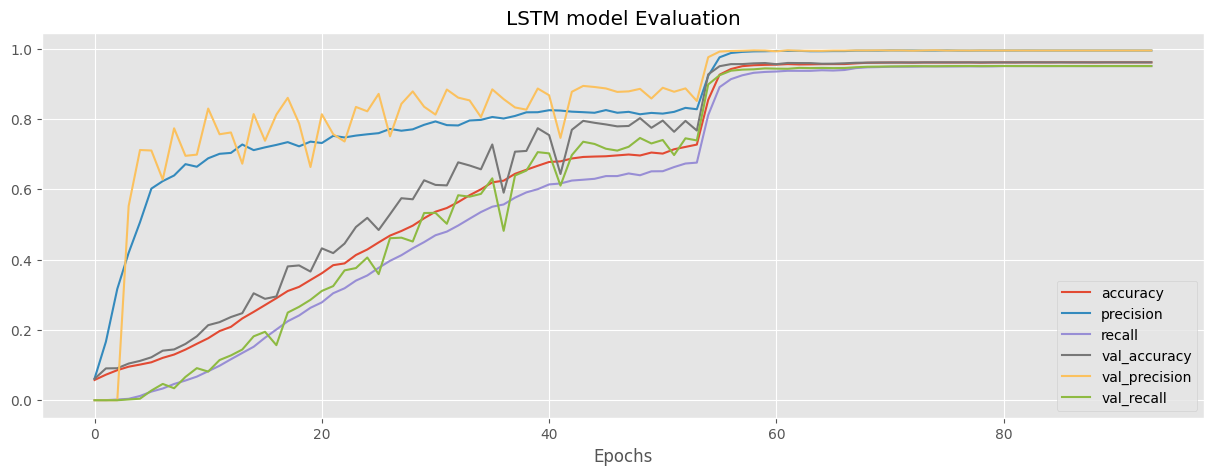

In [ ]:
lstm_result[["accuracy", "precision", "recall",
             "val_accuracy", "val_precision", "val_recall"]].plot(figsize=(15, 5),
                                                                        title="LSTM model Evaluation", xlabel="Epochs")
plt.show()

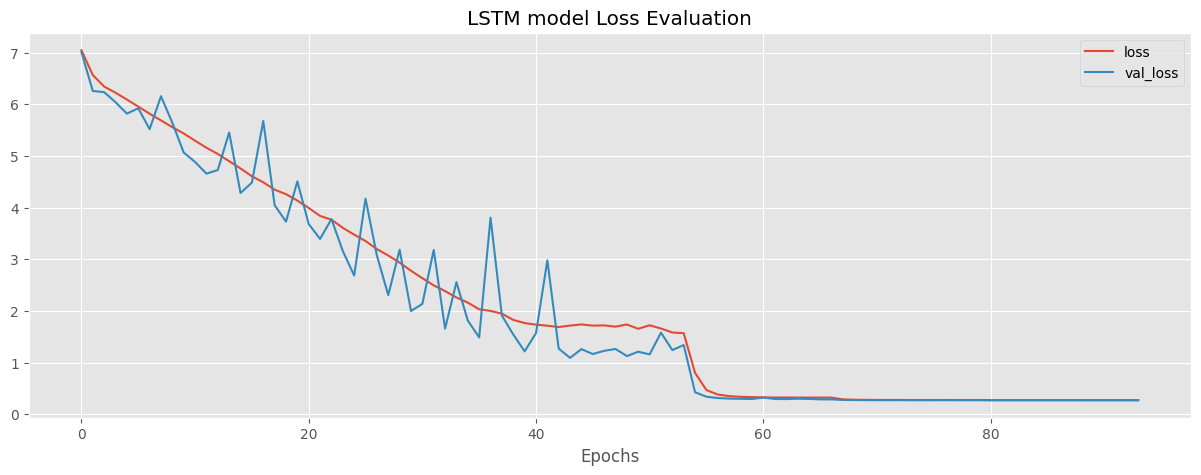

In [ ]:
lstm_result[["loss", "val_loss"]].plot(figsize=(15, 5), title="LSTM model Loss Evaluation", xlabel="Epochs")
plt.show()

In [ ]:
def BuildGRUModel(input_shape, input_dim, output_dim, num_of_output):
    input_layer = Input(shape=input_shape)
    x = layers.Embedding(input_dim=input_dim, output_dim=output_dim)(input_layer)
    x = layers.GRU(units=128, activation="tanh")(x)
    x = layers.Dense(units=64, activation="relu")(x)
    output_layer = layers.Dense(units=num_of_output, activation="softmax")(x)

    final_model = Model(input_layer, output_layer)

    final_model.summary()

    final_model.compile(optimizer=optimizers.RMSprop(learning_rate=0.01),
                        loss="categorical_crossentropy",
                        metrics=["accuracy",
                                 tf.keras.metrics.Precision(name="precision"),
                                 tf.keras.metrics.Recall(name="recall")
                                 ]
                        )

    return final_model

In [ ]:
gru_model = BuildGRUModel(input_shape,
                           total_number_of_words,
                           max_sentence_length,
                           total_number_of_words)

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_14 (Embedding)        │ (None, 17, 18)         │       153,108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │        56,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 8506)           │       552,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771,086 (2.94 MB)

 Trainable params: 771,086 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = gru_model.fit(X, y,
                        validation_data=(X, y),
                        epochs=100,
                        batch_size=32,
                        callbacks=[callbacks.ReduceLROnPlateau(patience=5, monitor="val_accuracy"),
                                   callbacks.EarlyStopping(patience=10, monitor="val_accuracy")])

Epoch 1/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.0486 - loss: 7.4896 - precision: 0.0447 - recall: 8.8646e-04 - val_accuracy: 0.0577 - val_loss: 6.5236 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0100
Epoch 2/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0657 - loss: 6.6158 - precision: 0.1908 - recall: 2.9223e-04 - val_accuracy: 0.0328 - val_loss: 6.7107 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0100
Epoch 3/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0673 - loss: 6.4543 - precision: 0.3826 - recall: 0.0012 - val_accuracy: 0.0632 - val_loss: 6.4849 - val_precision: 0.2734 - val_recall: 0.0428 - learning_rate: 0.0100
Epoch 4/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0764 - loss: 6.3651 - precision: 0.4725 - recall: 0.0121 - val_accuracy: 0.0761 - val_loss: 6.2465 - val_precision: 0.6508 - val_recall: 0.0128 - learning_rate: 0.0100
Epoch 5/100
302/302 ━━━━━━━━━━━━

In [ ]:
gru_result = pd.DataFrame(history.history)
gru_result

,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall,learning_rate
0,0.055850,7.083225,0.059701,0.000415,0.057718,6.523592,0.000000,0.000000,0.0100
1,0.065815,6.639236,0.250000,0.000415,0.032804,6.710666,0.000000,0.000000,0.0100
2,0.068203,6.503732,0.377778,0.001765,0.063220,6.484934,0.273391,0.042770,0.0100
3,0.073497,6.416592,0.478528,0.008097,0.076093,6.246546,0.650794,0.012769,0.0100
4,0.078065,6.320715,0.594470,0.013391,0.087512,6.054752,1.000000,0.002803,0.0100
...,...,...,...,...,...,...,...,...,...
95,0.957438,0.304835,0.991022,0.951106,0.960760,0.258068,0.993748,0.957023,0.0010
96,0.960656,0.261247,0.993749,0.957127,0.961175,0.253330,0.993864,0.958476,0.0001
97,0.960967,0.257707,0.993966,0.957542,0.961798,0.253951,0.994935,0.958476,0.0001
98,0.961487,0.257094,0.994076,0.958061,0.961694,0.252084,0.994295,0.958891,0.0001


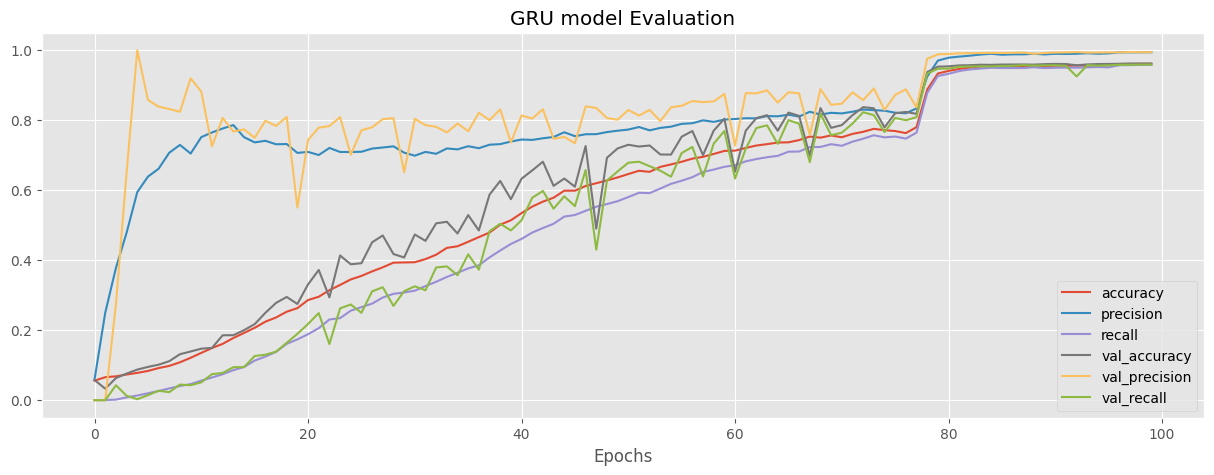

In [ ]:
gru_result[["accuracy", "precision", "recall",
             "val_accuracy", "val_precision", "val_recall"]].plot(figsize=(15, 5),
                                                                        title="GRU model Evaluation", xlabel="Epochs")
plt.show()

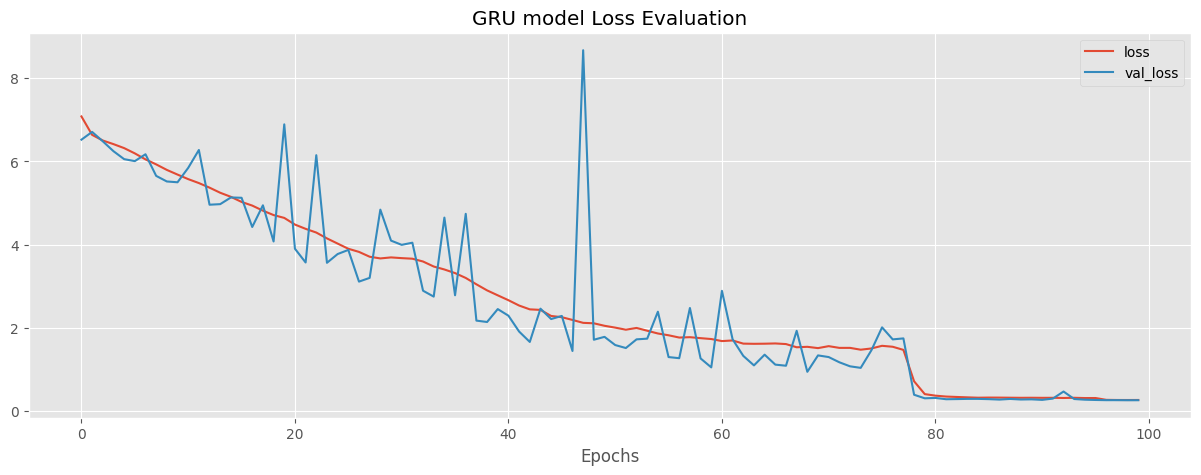

In [ ]:
gru_result[["loss", "val_loss"]].plot(figsize=(15, 5), title="GRU model Loss Evaluation", xlabel="Epochs")
plt.show()

## Model testing

In [ ]:
def GetnextNwords(model, prep_func, text, n_pred, tokenizer, max_sentence_length):
    generated_text = text

    for _ in range(n_pred):
        prep_text = prep_func(generated_text.lower())
        tokenized_text = tokenizer.texts_to_sequences([prep_text])
        padded_sequence = pad_sequences(tokenized_text, maxlen=max_sentence_length-1)

        wrd_index = np.argmax(model.predict(padded_sequence), axis=1)[0]
        wrd_pred = tokenizer.index_word.get(wrd_index)

        if wrd_pred:
            generated_text += " " + str(TextBlob(wrd_pred).correct()).strip()
        else:
            break

    print(" ".join(generated_text.split()))

In [ ]:
sample_text = "the smartest"

## LSTM

In [ ]:
GetnextNwords(lstm_model, prep_text, sample_text, 10, tokenizer, max_sentence_length)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
the smartest bachelor definite too none is websitedonate then photograph with miss


## GRU

In [ ]:
GetnextNwords(gru_model, prep_text, sample_text, 10, tokenizer, max_sentence_length)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
the smartest madam said also suicide below of never over the snow


## Eddy